# **Ada Project : Creative extension**
## Milestone P4

### **Supplementary method :** Decision tree

The idea of the original paper is to demonstarte (if possible) that there is a racial profiling trend across the united states, the authors do so by using severall methods that mostly take data across all available states. We have decided here to limit the search to one state, as we think that there may be different trends in the different states (As demonstrated for instance by the marijuane legalisation/search rate test). We also decided to implement a method that the paper hasn't used: The decision tree, which we think is a robust statistical test that correspond to the data we have. We know that our conclusions won't be able to caracterize the polices officers behaviour across the states but only to the specifical instance of the washington state patrol. 

In [1]:
#We first import all the libraries we will need

import pandas as pd
import numpy as np
import seaborn as sns

import matplotlib.pyplot as plt
import matplotlib

import warnings
import random

from datetime import datetime, date, time

from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.model_selection import RandomizedSearchCV,train_test_split, GridSearchCV
from sklearn import preprocessing
from sklearn.metrics import precision_score, recall_score
from sklearn.svm import LinearSVC


warnings.filterwarnings('ignore')

### **Step 1**:  Source of Data
The original paper gives a link to the source of their data the Stanford Open Policing project :https://openpolicing.stanford.edu/data/. Sevrall million of stops are categorized there but as we said we decided to limit ourselves to only one state, which we thought needed to be heavily populated and where state patrols had recorded  a lot of stops owith information on the racial appearence of the subjects, the time of the stop, the subject age, the subjet sex and if a search had been conducted. Our choice was therefore the state of washington and the 11 million state patrol stopps.

But this also meant that the file containing all these stops was really large and the computation time being so long we had to take only parts of the original csv.  To achieve this, as the data is sorted by date, we sampled the orignal dataset randomly and took a about 500 000. That is aproximately 4,5% . 

Some of us also had good enough computers to use the whole dataset, so we made it possible to switch.

In [2]:
#We first define which computer is used. For the final rendering we will use the whole dataset but we still decided to keep the other options.
computer ='Nathan'

In [3]:
#We also define constants that we may need 
#The year of the washington legalisation is 2012
wa_legalization_year=2012

In [4]:
#Loading our dataset splited in a random way for the different computers:
if computer =='Alex':
    filename = "Desktop/m_3/wa.csv" #path on Alex computer
    
    n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
    s = 500000 #desired sample size, longer sample sizes will significantly increase runtime
    skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list

    wa = pd.read_csv(filename, skiprows=skip) #uncomment this line and comment the following line for only importing s samples
    
elif computer == 'Jean':
    filename = "/Users/jeandevillard/Desktop/m_3/wa.csv" #path on Jean computer
    wa = pd.read_csv(filename)

elif computer == 'Nathan':
    filename = "data/wa_statewide_2020_04_01.csv" #where your data should be :)
    wa = pd.read_csv(filename)

In [5]:
wa.head()

,raw_row_number,date,time,location,lat,lng,county_name,subject_age,subject_race,subject_sex,...,frisk_performed,search_conducted,search_basis,raw_officer_race,raw_officer_gender,raw_contact_type,raw_driver_race,raw_driver_gender,raw_search_type,raw_enforcements
0,1,2009-10-27,11:00:00,S-012-344,46.114221,-118.224510,Walla Walla County,30.0,white,male,...,False,False,NaN,WHITE,-,--,White,M,N,-|-|-
1,2,2009-10-04,21:00:00,I-090-10,47.580522,-122.170289,King County,29.0,black,male,...,False,False,NaN,WHITE,-,--,African American,M,N,-|-
2,3,2009-10-04,03:00:00,I-090-72,47.250003,-121.189883,Kittitas County,25.0,white,male,...,False,False,NaN,WHITE,-,--,White,M,N,NaN
3,4,2009-10-04,13:00:00,S-014-3,45.615344,-122.612893,Clark County,19.0,white,female,...,False,False,NaN,WHITE,-,--,White,F,N,-|-|-|-|-|-
4,5,2009-10-11,08:00:00,S-003-40,47.590284,-122.698671,Kitsap County,25.0,white,male,...,False,False,NaN,WHITE,-,--,White,M,N,-|-


Before continuing we quickly check the diferent data types for each column that we have in our main dataframe.

In [6]:
wa.dtypes

raw_row_number          int64
date                   object
time                   object
location               object
lat                   float64
lng                   float64
county_name            object
subject_age           float64
subject_race           object
subject_sex            object
officer_race           object
officer_sex            object
department_name        object
type                   object
violation              object
arrest_made            object
citation_issued          bool
warning_issued           bool
outcome                object
contraband_found       object
frisk_performed          bool
search_conducted         bool
search_basis           object
raw_officer_race       object
raw_officer_gender     object
raw_contact_type       object
raw_driver_race        object
raw_driver_gender      object
raw_search_type        object
raw_enforcements       object
dtype: object

In [7]:
#It is important for the followings parts to get the columns of date and time into a datetime type.
#There ara many ways to do this tranformation of the data type but we decide to use the pandas function pd.to_datetime:

#First for the date column:
wa_datetime = pd.to_datetime(wa.date)
wa.date = wa_datetime

We verify that the transformation has worked.

In [36]:
wa.iloc[200000]

raw_row_number                         215317
date                      2011-10-11 00:00:00
time                                 01:00:00
location                            I-005-197
lat                                   48.0441
lng                                  -122.181
county_name                  Snohomish County
subject_age                                20
subject_race                            white
subject_sex                            female
officer_race                            white
officer_sex                              male
department_name       Washington State Patrol
type                                vehicular
violation                                 NaN
arrest_made                             False
citation_issued                         False
warning_issued                           True
outcome                               warning
contraband_found                          NaN
frisk_performed                         False
search_conducted                  

We now want to split our dataset and create new ones that will contain information of two years each (We will take out the first year the year of legalization and the last year so that we are sure that the data is as complete and homogenoeus as possible)

In [9]:
#We first reduce the dataframe to only the elements that interest us and we sort them according to the date
wa_reduced=wa.loc[:,['date','subject_age','subject_race','subject_sex','search_conducted']]
wa_reduced = wa_reduced.dropna()
wa_reduced=wa_reduced.sort_values(by=['date'])

In [10]:
wa_reduced_year=[]
for date_ in wa_reduced.date:
    wa_reduced_year.append(date_.year)
wa_reduced['year']=wa_reduced_year

In [14]:
wa_reduced=wa_reduced.loc[:,['year','subject_age','subject_race','subject_sex','search_conducted']]

We also want to drop all races that are not white, hispanic, or black
Also all sexes that are not male or female (I did not notice any, but this is just a precaution)
This is for simplification purposes, and also to fit the study results as well as possible 

In [15]:
wa_reduced = wa_reduced[wa_reduced['subject_race'].isin(['black','hispanic','white'])]
wa_reduced = wa_reduced[wa_reduced['subject_sex'].isin(['male','female'])]

In [19]:
def intervals_from_dataframe(dataframe, legislation_date, drop_element):
    #We want to repeat this action for every dataframe we might use so we programmed this function
    
    #As the dataframe is sorted the year of the first element and the year of the last element
    #should respectively be the first and the last year of the dataset
    begin_year=dataframe.year.iloc[0]
    end_year=dataframe.year.iloc[-1]
    
    #We first create a linear range without the borders
    year_range=np.arange(begin_year+1,end_year,1)
    time_intervals=[]
    
    #We then try to pair the years. If there is an odd amount of year we will drop the element specified
    #in the "drop_element" variable.
    
    #If the amount of years is even we set the drop_element to -1 so no element will be dropped
    if len(year_range)%2 == 0:
        drop_element=-1
    
    #we then go through the year_range vector and group the years two by two 
    k=0
    for i in range(len(year_range)):
        if i != drop_element:
            if k== 0:
                if (year_range[i]!=legislation_date) and (year_range[i]-1 !=legislation_date):
                    time_intervals.append([year_range[i]])
                    k=k+1
            elif k==1:
                if (year_range[i]!= legislation_date) and (year_range[i]-1 !=legislation_date):
                    k=0
                    time_intervals[-1].append(year_range[i])
    return time_intervals

In [51]:
def prep_from_time_intervals(dataframe,time_intervals):
    #We can now create the different dataframes
    dataframes=[]    
    for time_interval in time_intervals:
        dataframes.append((dataframe.loc[(dataframe.year==time_interval[0]) | (dataframe.year==time_interval[1] )]).loc[:,['subject_age','subject_race','subject_sex','search_conducted']] )
    return dataframes

In [20]:
time_intervals=intervals_from_dataframe(wa_reduced, wa_legalization_year, 0)
time_intervals

[[2010, 2011], [2014, 2015], [2016, 2017]]

In [52]:
wa_collection=prep_from_time_intervals(wa_reduced,time_intervals)

In [53]:
wa_collection[0].head()

,subject_age,subject_race,subject_sex,search_conducted
1313459,54.0,white,male,False
1283533,23.0,white,male,False
1309749,39.0,white,female,False
1259220,43.0,black,male,False
1283451,28.0,white,male,False


### **Step 2**: Statistics

We will now perform a decision tree analysis of our data. This is convenient because we have both categorical and numerical variables as inputs, and because the decision tree will ultimately return the factors which are more important to determine if a subject will be searched or not.

We could have used a random forest analysis for better precision, but we found the decision tree analysis to be more convenient. The main reason is that decision trees are easy to represent, and are white box models, whereas random forests are more accurate but they are black box models, harder to represent, and impossible to run by hand.

We will use sklearn to do this

The first thing we will need to do is to split our data into a training and testing set.

This is extremely important to prevent overfitting, which is the main risk of a decision tree analysis (most of the work we will do to prevent this will be afterwards on hyperparameter tuning)

We will divide data( already divided into time intervals) into 3 sets :
A training set to train our decision tree classifier
A validation set to tune our hyperparameters
A testing set to check our results on "never seen before" data

Since the dataset is so big, we will only use 10% of it as testing and 10% of it as validation.


Unfortunately, sklearn does not handle categorical values for decision trees.

Hence, we have to use label encoding to switch categorical values into numerical values.
We will also turn our search_conducted values to binary

We will repeat all this on all time intervals

In [54]:
print(len(time_intervals))

3


In [59]:
def label_encoding (df):
    LE_race = preprocessing.LabelEncoder()
    LE_sex = preprocessing.LabelEncoder()

    df['subject_race'] = LE_race.fit_transform(df['subject_race'])
    df['subject_sex'] = LE_sex.fit_transform(df['subject_sex'])

    df['search_conducted'] = df['search_conducted'].astype(int)

    print(df.head())
    
    return df

In [60]:
wa_collection[0]=label_encoding(wa_collection[0])

         subject_age  subject_race  subject_sex  search_conducted
1313459         54.0             2            1                 0
1283533         23.0             2            1                 0
1309749         39.0             2            0                 0
1259220         43.0             0            1                 0
1283451         28.0             2            1                 0


In [61]:
wa_collection[1]=label_encoding(wa_collection[1])

         subject_age  subject_race  subject_sex  search_conducted
1702054         54.0             2            0                 0
1686381         26.0             1            0                 0
1706436         60.0             2            1                 0
1683395         52.0             2            0                 0
1675818         29.0             2            1                 0


In [62]:
wa_collection[2]=label_encoding(wa_collection[2])

         subject_age  subject_race  subject_sex  search_conducted
9278694         34.0             2            1                 0
9278695         31.0             2            1                 0
9314036         27.0             2            1                 0
9314035         36.0             2            1                 0
9314014         33.0             2            0                 0


Hence : 

**race** : black = 0, white = 2, hispanic = 1

**sex** : female = 0, male = 1

We will be able to get back the original results by using the inverse_transform method

Before we perform the split between training, testing and validation sets, we can just check the global proportion of searches.

In [63]:
def check_global_proportion(df):
    A = df[df['search_conducted'] == True].shape[0]
    B = df.shape[0]
    print(A/B)

In [64]:
check_global_proportion(wa_collection[0])

0.033105342379307214


In [65]:
check_global_proportion(wa_collection[1])

0.024495047008109193


In [66]:
check_global_proportion(wa_collection[2])

0.02740529176752406


We can see that less than 3% of our drivers are searched. Our dataset is extremely imbalanced and thus we need to be extremely careful when fitting models. From now everytime we talk about a positive we refer to a search.

We can now perform our split, but also scale all values in order to handle them more effectively

In [69]:
def split(df):
    X = df[['subject_age','subject_race','subject_sex']].values
    Y = df[['search_conducted']].values

    X_scale = preprocessing.scale(X)

    X_train, X_test, Y_train, Y_test = train_test_split(X_scale,Y,test_size = 0.2) #training set : 80% of samples
    X_test, X_val, Y_test, Y_val = train_test_split(X_test, Y_test, test_size = 0.5) #10% testing 10% validation
    
    return X_train, X_test, Y_train, Y_test, X_val, Y_val

In [70]:
wa_sets=[]
for df in wa_collection:
    X_train, X_test, Y_train, Y_test, X_val, Y_val=split(df)
    wa_sets.append([X_train, X_test, Y_train, Y_test, X_val, Y_val])


Now we will define our decision trees.

Most parameters (min_samples_leaf, min_samples_split) are not really important based on the number of samples

However, the ones that will really be important for our model are the max_tree_depth, criterion and splitter 

max_tree_depth is especially important because it will ultimately be this parameter that determines which factors are important to evaluate if a subject will be searched

First, we will evaluate the tree with only 3 levels.

We will perform the same fit, but with other methods in order to ensure that our results are coherent.

We will evaluate them based on accuracy, precision (fraction of our predicted positives that are true positives) and recall (fraction of all actual positives that are true positives).

Just as another check, we will calculate these indicators on the training set. This is only to ensure that nothing went wrong, since during testing I ended up with an accuracy of 0 on the training set, which indicated an error in my code.

We are going to use the first time interval as an example and to comment our method.

In [71]:
X_train= wa_sets[0][0]
X_test= wa_sets[0][1]
Y_train= wa_sets[0][2]
Y_test= wa_sets[0][3]
X_val= wa_sets[0][4]
Y_val= wa_sets[0][5]

In [72]:
WA_tree_example = DecisionTreeClassifier()
WA_tree_example.set_params(max_depth = 3)
WA_tree_example.fit(X_train,Y_train)

DecisionTreeClassifier(max_depth=3)

In [73]:
print("Accuracy on training set: {:.3f}".format(WA_tree_example.score(X_train,Y_train)))
print("Precision on training set: {:.3f}".format(precision_score(Y_train,WA_tree_example.predict(X_train), average = 'macro')))
print("Recall on training set: {:.3f}".format(recall_score(Y_train,WA_tree_example.predict(X_train), average = 'macro')))

Accuracy on training set: 0.967
Precision on training set: 0.483
Recall on training set: 0.500


In [74]:
print("Accuracy on testing set: {:.3f}".format(WA_tree_example.score(X_test,Y_test)))
print("Precision on testing set: {:.3f}".format(precision_score(Y_test,WA_tree_example.predict(X_test), average = 'macro')))
print("Recall on testing set: {:.3f}".format(recall_score(Y_test,WA_tree_example.predict(X_test), average = 'macro')))

Accuracy on testing set: 0.967
Precision on testing set: 0.483
Recall on testing set: 0.500


In [75]:
WA_tree_example = LogisticRegression()
WA_tree_example.fit(X_train,Y_train)

LogisticRegression()

In [76]:
print("Accuracy on training set: {:.3f}".format(WA_tree_example.score(X_train,Y_train)))
print("Precision on training set: {:.3f}".format(precision_score(Y_train,WA_tree_example.predict(X_train), average = 'macro')))
print("Recall on training set: {:.3f}".format(recall_score(Y_train,WA_tree_example.predict(X_train), average = 'macro')))

Accuracy on training set: 0.967
Precision on training set: 0.483
Recall on training set: 0.500


In [77]:
print("Accuracy on testing set: {:.3f}".format(WA_tree_example.score(X_test,Y_test)))
print("Precision on testing set: {:.3f}".format(precision_score(Y_test,WA_tree_example.predict(X_test), average = 'macro')))
print("Recall on testing set: {:.3f}".format(recall_score(Y_test,WA_tree_example.predict(X_test), average = 'macro')))

Accuracy on testing set: 0.967
Precision on testing set: 0.483
Recall on testing set: 0.500


In [78]:
WA_tree_example = SGDClassifier(loss='hinge',penalty='l2',max_iter=1000)
WA_tree_example.fit(X_train,Y_train)

SGDClassifier()

In [79]:
print("Accuracy on training set: {:.3f}".format(WA_tree_example.score(X_train,Y_train)))
print("Precision on training set: {:.3f}".format(precision_score(Y_train,WA_tree_example.predict(X_train), average = 'macro')))
print("Recall on training set: {:.3f}".format(recall_score(Y_train,WA_tree_example.predict(X_train), average = 'macro')))

Accuracy on training set: 0.967
Precision on training set: 0.483
Recall on training set: 0.500


In [80]:
print("Accuracy on testing set: {:.3f}".format(WA_tree_example.score(X_test,Y_test)))
print("Precision on testing set: {:.3f}".format(precision_score(Y_test,WA_tree_example.predict(X_test), average = 'macro')))
print("Recall on testing set: {:.3f}".format(recall_score(Y_test,WA_tree_example.predict(X_test), average = 'macro')))

Accuracy on testing set: 0.967
Precision on testing set: 0.483
Recall on testing set: 0.500


The values for the respective indicators are extremely consistent on both the training and testing set, and no matter the model we used. Therefore, we can conclude that a decision tree analysis is appropriate. Precision and recall are not optimal, but considering the small proportion of positives in the population they are actually sufficient. Moreover, what this tells us is that there is still a huge human factor in searches which we cannnot take into account in our estimations.

We will now plot the three trees and make our first observations

In [84]:
trees=[]
for sets in wa_sets:
    new_tree = DecisionTreeClassifier()
    new_tree.set_params(max_depth = 3)
    new_tree.fit(sets[0],sets[2])
    trees.append(new_tree)

### **Step 3**:  Visualization
We now want to visualize the results of our analysis

[Text(558.0, 380.52, 'subject_age <= -0.162\ngini = 0.064\nsamples = 1303209\nvalue = [1260124, 43085]'),
 Text(279.0, 271.8, 'subject_race <= -0.616\ngini = 0.083\nsamples = 653678\nvalue = [625344, 28334]'),
 Text(139.5, 163.07999999999998, 'subject_sex <= -0.363\ngini = 0.121\nsamples = 118687\nvalue = [110979, 7708]'),
 Text(69.75, 54.360000000000014, 'gini = 0.075\nsamples = 31532\nvalue = [30303, 1229]'),
 Text(209.25, 54.360000000000014, 'gini = 0.138\nsamples = 87155\nvalue = [80676, 6479]'),
 Text(418.5, 163.07999999999998, 'subject_sex <= -0.363\ngini = 0.074\nsamples = 534991\nvalue = [514365, 20626]'),
 Text(348.75, 54.360000000000014, 'gini = 0.056\nsamples = 197429\nvalue = [191707, 5722]'),
 Text(488.25, 54.360000000000014, 'gini = 0.084\nsamples = 337562\nvalue = [322658, 14904]'),
 Text(837.0, 271.8, 'subject_age <= 0.905\ngini = 0.044\nsamples = 649531\nvalue = [634780, 14751]'),
 Text(697.5, 163.07999999999998, 'subject_race <= -2.613\ngini = 0.055\nsamples = 384109\

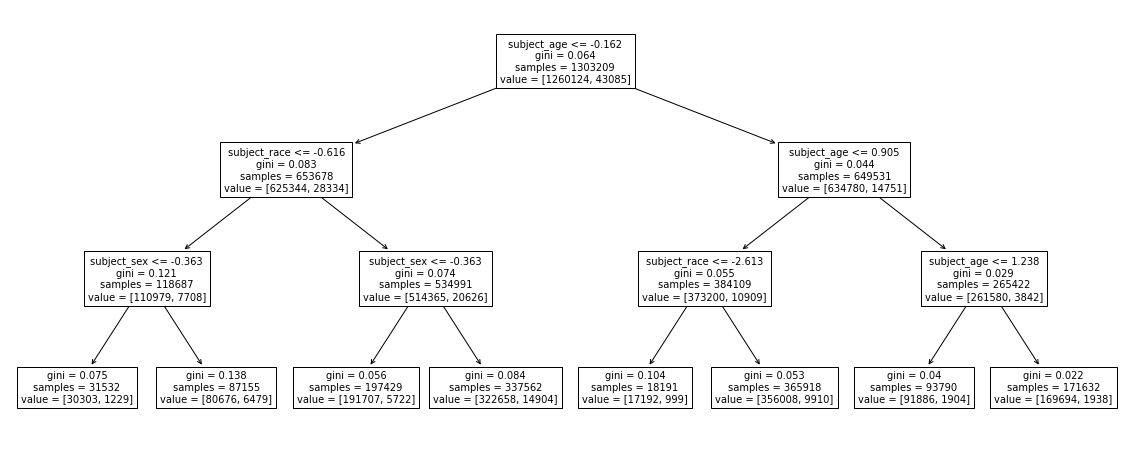

In [85]:
fig, axis = plt.subplots(figsize=(20, 8))
plot_tree(trees[0], ax=axis, feature_names=['subject_age','subject_race','subject_sex'])

[Text(558.0, 380.52, 'subject_age <= 0.076\ngini = 0.048\nsamples = 1218172\nvalue = [1188342, 29830]'),
 Text(279.0, 271.8, 'subject_race <= -0.517\ngini = 0.059\nsamples = 702769\nvalue = [681558, 21211]'),
 Text(139.5, 163.07999999999998, 'subject_sex <= -0.355\ngini = 0.084\nsamples = 145448\nvalue = [139079, 6369]'),
 Text(69.75, 54.360000000000014, 'gini = 0.052\nsamples = 40888\nvalue = [39787, 1101]'),
 Text(209.25, 54.360000000000014, 'gini = 0.096\nsamples = 104560\nvalue = [99292, 5268]'),
 Text(418.5, 163.07999999999998, 'subject_sex <= -0.355\ngini = 0.052\nsamples = 557321\nvalue = [542479, 14842]'),
 Text(348.75, 54.360000000000014, 'gini = 0.04\nsamples = 204570\nvalue = [200392, 4178]'),
 Text(488.25, 54.360000000000014, 'gini = 0.059\nsamples = 352751\nvalue = [342087, 10664]'),
 Text(837.0, 271.8, 'subject_age <= 1.385\ngini = 0.033\nsamples = 515403\nvalue = [506784, 8619]'),
 Text(697.5, 163.07999999999998, 'subject_race <= -2.392\ngini = 0.038\nsamples = 382970\nv

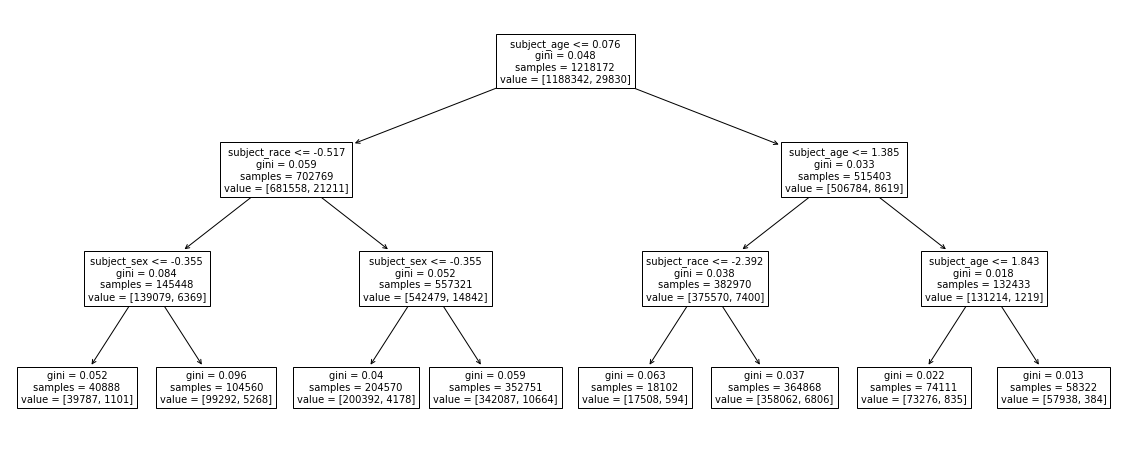

In [86]:
fig, axis = plt.subplots(figsize=(20, 8))
plot_tree(trees[1], ax=axis, feature_names=['subject_age','subject_race','subject_sex'])

[Text(558.0, 380.52, 'subject_age <= 0.161\ngini = 0.053\nsamples = 1050658\nvalue = [1021990, 28668]'),
 Text(279.0, 271.8, 'subject_race <= -0.469\ngini = 0.063\nsamples = 641106\nvalue = [620072, 21034]'),
 Text(139.5, 163.07999999999998, 'subject_sex <= -0.358\ngini = 0.087\nsamples = 137940\nvalue = [131623, 6317]'),
 Text(69.75, 54.360000000000014, 'gini = 0.051\nsamples = 39079\nvalue = [38061, 1018]'),
 Text(209.25, 54.360000000000014, 'gini = 0.101\nsamples = 98861\nvalue = [93562, 5299]'),
 Text(418.5, 163.07999999999998, 'subject_sex <= -0.358\ngini = 0.057\nsamples = 503166\nvalue = [488449, 14717]'),
 Text(348.75, 54.360000000000014, 'gini = 0.045\nsamples = 184463\nvalue = [180187, 4276]'),
 Text(488.25, 54.360000000000014, 'gini = 0.063\nsamples = 318703\nvalue = [308262, 10441]'),
 Text(837.0, 271.8, 'subject_age <= 1.403\ngini = 0.037\nsamples = 409552\nvalue = [401918, 7634]'),
 Text(697.5, 163.07999999999998, 'subject_race <= -2.274\ngini = 0.043\nsamples = 295942\nv

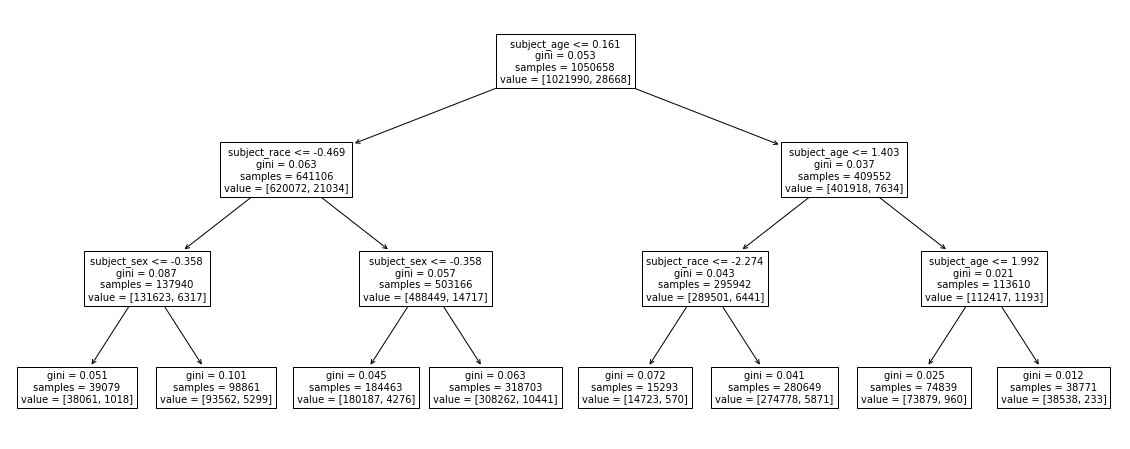

In [88]:
fig, axis = plt.subplots(figsize=(20, 8))
plot_tree(trees[2], ax=axis, feature_names=['subject_age','subject_race','subject_sex'])

Based on these trees, we can already draw some conclusions. The first one is that subject age seems to be the most important factor in determining if a subject will be searched or not. Intuitively, we can assume that police officers are not really suspicious, or eager to search elderly drivers. Thus, this seems coherent. Race seems to be the second most important factor, as expected with the study results, but the subject sex seems to practically be as important as the subject race. 

### **Step 4** : Optimization

We will perform a grid search cross validation. We could also perform a randomized search, but here we will test relatively few combinations of hyperparameters, so a grid search will not take too much time to compute, which is the main risk to this method and the main argument to choose a randomized search over it.

Here we will try different parameters :

gini or entropy criterion

best or random splitter

The last one is especially important because it will determine the number of factors needed to make the best prediction possible of our data

We will use as scoring precision, since we mainly want to improve our search rate predictions, and since they are already few searches.

In [94]:
grid_searches=[]
for sets in wa_sets: 
    WA_tree = DecisionTreeClassifier()

    parameters = {'criterion' : ('gini','entropy'), 'splitter' : ('best','random'), 'max_depth'  : [1,10]}
    new_GS = GridSearchCV(WA_tree, parameters, scoring = 'precision')
    new_GS.fit(sets[4], sets[5])
    grid_searches.append(new_GS)

In [95]:
for i in range(len(grid_searches)):
    print("Time interval :"+ str(time_intervals[i][0]) + "-" + str(time_intervals[i][1]))
    print('Best criterion:', grid_searches[i].best_estimator_.get_params()['criterion'])
    print('Best splitter:',  grid_searches[i].best_estimator_.get_params()['splitter'])
    print(grid_searches[i].best_estimator_.get_params(['WA_tree']))
    print()

Time interval :2010-2011
Best criterion: gini
Best splitter: best
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 10, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}

Time interval :2014-2015
Best criterion: gini
Best splitter: best
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_decrease': 0.0, 'min_impurity_split': None, 'min_samples_leaf': 1, 'min_samples_split': 2, 'min_weight_fraction_leaf': 0.0, 'presort': 'deprecated', 'random_state': None, 'splitter': 'best'}

Time interval :2016-2017
Best criterion: gini
Best splitter: best
{'ccp_alpha': 0.0, 'class_weight': None, 'criterion': 'gini', 'max_depth': 1, 'max_features': None, 'max_leaf_nodes': None, 'min_impurity_dec

In [76]:
WA_tree = GS_WA.best_estimator_.fit(X_train,Y_train)

In [77]:
print("Accuracy on training set: {:.3f}".format(WA_tree.score(X_train,Y_train)))
print("Precision on training set: {:.3f}".format(precision_score(Y_train,WA_tree.predict(X_train), average = 'macro')))
print("Recall on training set: {:.3f}".format(recall_score(Y_train,WA_tree.predict(X_train), average = 'macro')))

Accuracy on training set: 0.970
Precision on training set: 0.985
Recall on training set: 0.500


In [78]:
print("Accuracy on testing set: {:.3f}".format(WA_tree.score(X_test,Y_test)))
print("Precision on testing set: {:.3f}".format(precision_score(Y_test,WA_tree.predict(X_test), average = 'macro')))
print("Recall on testing set: {:.3f}".format(recall_score(Y_test,WA_tree.predict(X_test), average = 'macro')))

Accuracy on testing set: 0.971
Precision on testing set: 0.485
Recall on testing set: 0.500
